<a href="https://colab.research.google.com/github/kanish-dev/neural-nets-learnings/blob/main/makemore_1_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!wget https://raw.githubusercontent.com/kanish-dev/neural-nets-learnings/main/names.txt

--2023-03-04 06:19:52--  https://raw.githubusercontent.com/kanish-dev/neural-nets-learnings/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-03-04 06:19:52 (8.57 MB/s) - ‘names.txt’ saved [228146/228146]



In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [52]:
len(words)

32033

In [53]:
# building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [60]:
# build the dataset
block_size = 3
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
# MLP
n_embd = 10      # the dimensionality of the character embedding vector
n_hidden = 200  # the number of neurons in hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),             generator=g)
W1= torch.randn((n_embd * block_size, n_hidden), generator=g)
b1= torch.randn(n_hidden,                        generator=g)
W2= torch.randn((n_hidden,vocab_size),           generator=g)
b2= torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [62]:
from torch.autograd import backward
# Optimaization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]   # embed characters to vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vectors
  hpreact =  embcat @ W1 + b1  # (N, n_hidden)
  h = torch.tanh(hpreact)   
  logits = h @ W2 + b2    #(N, vaocab_size)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data +=  -lr * p.grad
    
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d} {loss.item(): .4f}')
  lossi.append(loss.log10().item())    

      0/ 200000  27.8817
  10000/ 200000  2.9415
  20000/ 200000  2.5069
  30000/ 200000  2.7998
  40000/ 200000  2.0261
  50000/ 200000  2.5863
  60000/ 200000  2.3420
  70000/ 200000  2.0952
  80000/ 200000  2.3454
  90000/ 200000  2.2365
 100000/ 200000  2.1080
 110000/ 200000  2.3831
 120000/ 200000  1.9898
 130000/ 200000  2.4591
 140000/ 200000  2.1910
 150000/ 200000  2.1606
 160000/ 200000  2.1811
 170000/ 200000  1.7997
 180000/ 200000  2.0962
 190000/ 200000  1.8052


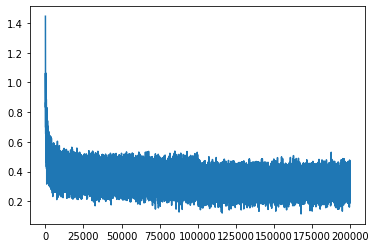

In [63]:
plt.plot(lossi)

In [64]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr,Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte)
  }[split]
  emb = C[x]   # embed characters to vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vectors
  h =  torch.tanh(embcat @ W1 + b1 ) # (N, n_hidden)  
  logits = h @ W2 + b2    #(N, vaocab_size)
  loss = F.cross_entropy(logits, y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.127678871154785
val 2.1750576496124268


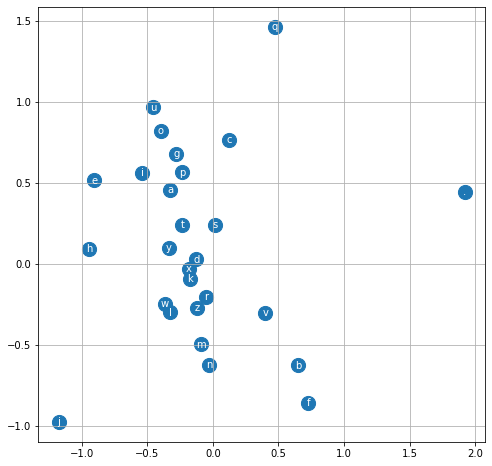

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200 )
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [66]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initilize with all ...
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])] # (1,block_size, n_embd)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 +b2 
    probs = F.softmax(logits,dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    if  ix == 0:
      break

  print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
myli.
taty.
skanden.
jazonen.
amerynchireei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wanthoniearyn.
kai.
everusabee.
demiia.
